In [4]:
import pandas as pd 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_theme()


In [5]:
df=pd.read_csv('D:\\INSEA\\Stage PFA\\Stage Ministère de finance\\data\\tourism\\TES_with_feuters.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
#df = df.asfreq('MS')  # MS = Month Start
#df = df.sort_index()
df['TES']=df['TES'].replace(0,1)

##### sentiment anlysis data preparation

In [3]:
# sa=pd.read_csv("D:\\INSEA\\Stage PFA\\Stage Ministère de finance\\data\\reviews\\reviews_month_imputed.csv")


In [4]:
# def prepar(data):
#     results=[]
#     dates=list(data['month'].unique())
#     for d in dates:
#         L=data[data["month"]==d]
#         NSI=(len(L[L["sentiment_label"]=="positive"])-len(L[L["sentiment_label"]=="negative"]))/len(L)
#         #avg_neg=-1*len(L[L["sentiment_label"]=="negative"])/len(L)
#         results.append({
#             "date":d,
#             "review_count":len(L),
#             "NSI":round(NSI,3)
#         })
#     return pd.DataFrame(results)
# sentiments=prepar(sa)

In [5]:
# sentiments['date']=pd.to_datetime(sentiments['date'])
# #sentiments = sentiments.asfreq('MS')

In [6]:
# all=pd.merge(df,sentiments,on='date',how='outer')
# all.set_index('date', inplace=True)
# all=all.dropna(subset='TES')
# all['review_count'] = all['review_count'].interpolate(method='time')
# #all['NSI'] = all['NSI'].fillna(0)
# all['NSI'] = all['NSI'].interpolate(method='time')
# all['NSI']=all['NSI'].shift(1)
# all['review_count'] = all['review_count'].shift(1)
# #all
# print(all.corr())

In [7]:
#df['TES_log'] = np.log(df['TES'] + 1)

In [6]:
#Variable: is_pandemic =>  To explain COVID-19 effect

# pandemic_start = '2020-01-01'
# pandemic_end = '2022-09-30'
# df['is_pandemic'] = 0
# df.loc[pandemic_start:pandemic_end, 'is_pandemic'] = 1

exog_variables = [
    "is_pandemic",
    "marrakech_lag_1",
    "NSI",
    "review_count"
]

In [7]:
print(df.corr())

                      TES  marrakech_lag_1  review_count       NSI  \
TES              1.000000         0.826469      0.139843 -0.044970   
marrakech_lag_1  0.826469         1.000000      0.142453 -0.058254   
review_count     0.139843         0.142453      1.000000 -0.432300   
NSI             -0.044970        -0.058254     -0.432300  1.000000   
is_pandemic     -0.655924        -0.471885      0.067685 -0.015506   

                 is_pandemic  
TES                -0.655924  
marrakech_lag_1    -0.471885  
review_count        0.067685  
NSI                -0.015506  
is_pandemic         1.000000  


In [8]:
df.dropna(inplace=True)
len(df)

183

In [9]:
print(df.corr())

                      TES  marrakech_lag_1  review_count       NSI  \
TES              1.000000         0.826469      0.139843 -0.044970   
marrakech_lag_1  0.826469         1.000000      0.142453 -0.058254   
review_count     0.139843         0.142453      1.000000 -0.432300   
NSI             -0.044970        -0.058254     -0.432300  1.000000   
is_pandemic     -0.655924        -0.471885      0.067685 -0.015506   

                 is_pandemic  
TES                -0.655924  
marrakech_lag_1    -0.471885  
review_count        0.067685  
NSI                -0.015506  
is_pandemic         1.000000  


In [10]:
train=df.loc['01-2010':'11-2023']
test=df.loc['12-2023':]
print("taille du train:",len(train),"\ntaille du test :",len(test))
X_train = train[exog_variables]
X_test= test[exog_variables]
y_train = train['TES']
y_test= test['TES']
print("taille du train:",X_train.shape,"\ntaille du test :",X_test.shape)

taille du train: 166 
taille du test : 17
taille du train: (166, 4) 
taille du test : (17, 4)


In [13]:
# def grid_search_sarima(train_data, colonne='TES',
#                        p_range=range(0, 2), d_range=range(1,2), q_range=range(0, 2),
#                        P_range=range(0, 3), D_range=range(1,3), Q_range=range(0, 3),
#                        s=[12]):
#     print("\n" + "="*70)
#     print("GRID SEARCH SARIMA - VERSION OPTIMISÉE")
#     print("="*70)
#     # Générer toutes les combinaisons
#     pdq = list(itertools.product(p_range, d_range, q_range))
#     seasonal_pdq = list(itertools.product(P_range, D_range, Q_range, s))
    
#     total_models = len(pdq) * len(seasonal_pdq)
#     print(f"\nNombre total de modèles à tester: {total_models}")
#     print("Démarrage de la recherche...\n")
#     # Variables pour stocker uniquement le meilleur
#     meilleur_aic = np.inf
#     meilleur_modele = None
#     meilleur_params = None
#     meilleur_params_seasonal = None
#     meilleur_bic = None
    
#     compteur = 0
#     modeles_testes = 0
    
#     for param in pdq:
#         for param_seasonal in seasonal_pdq:
#             compteur += 1
            
#             try:
#                 # Ajuster le modèle
#                 model = SARIMAX(train_data[colonne],exog=train_data[exog_variables],
#                                order=param,
#                                seasonal_order=param_seasonal)
                
#                 results = model.fit(disp=False, maxiter=200)
#                 modeles_testes += 1
                
#                 # Garder uniquement si c'est le meilleur
#                 if results.aic < meilleur_aic:
#                     meilleur_aic = results.aic
#                     meilleur_bic = results.bic
#                     meilleur_modele = results
#                     meilleur_params = param
#                     meilleur_params_seasonal = param_seasonal
                    
#                     # Afficher quand on trouve un meilleur modèle
#                     print(f"  ✓ Nouveau meilleur: SARIMA{param}x{param_seasonal} - AIC: {results.aic:.2f}")
                
#                 # Afficher progression
#                 if compteur % 10 == 0 or compteur == total_models:
#                     print(f"  Progression: {compteur}/{total_models} combinaisons testées ({modeles_testes} réussies)...")
                
#             except Exception as e:
#                 # Ignorer les modèles qui ne convergent pas
#                 continue
    
#     # Vérifier qu'au moins un modèle a convergé
#     if meilleur_modele is None:
#         raise ValueError("❌ Aucun modèle n'a convergé ! Essayez avec des plages de paramètres différentes.")
    
#     print("\n" + "="*70)
#     print("🏆 MEILLEUR MODÈLE TROUVÉ")
#     print("="*70)
#     print(f"SARIMA{meilleur_params}x{meilleur_params_seasonal}")
#     print(f"AIC: {meilleur_aic:.2f}")
#     print(f"BIC: {meilleur_bic:.2f}")
#     print(f"\nModèles testés avec succès: {modeles_testes}/{total_models}")
    
#     return {
#         'params': meilleur_params,
#         'seasonal_params': meilleur_params_seasonal,
#         'aic': meilleur_aic,
#         'bic': meilleur_bic,
#         'model': meilleur_modele
#     }

In [14]:
def grid_search_sarima(train_data, colonne='TES',
                       p_range=range(0, 2), d_range=range(1,2), q_range=range(0, 2),
                       P_range=range(0, 3), D_range=range(1, 3), Q_range=range(0, 3),
                       s=[12]):
    print("\n" + "="*70)
    print("GRID SEARCH SARIMA - VERSION OPTIMISÉE")
    print("="*70)
    # Générer toutes les combinaisons
    pdq = list(itertools.product(p_range, d_range, q_range))
    seasonal_pdq = list(itertools.product(P_range, D_range, Q_range, s))
    
    total_models = len(pdq) * len(seasonal_pdq)
    print(f"\nNombre total de modèles à tester: {total_models}")
    print("Démarrage de la recherche...\n")
    # Variables pour stocker uniquement le meilleur
    meilleur_aic = np.inf
    meilleur_modele = None
    meilleur_params = None
    meilleur_params_seasonal = None
    meilleur_bic = None
    
    compteur = 0
    modeles_testes = 0
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            compteur += 1
            
            try:
                # Ajuster le modèle
                model = SARIMAX(train_data[colonne],exog=train_data[exog_variables],
                               order=param,
                               seasonal_order=param_seasonal)
                
                results = model.fit(disp=False, maxiter=200)
                modeles_testes += 1
                
                # Garder uniquement si c'est le meilleur
                if results.aic < meilleur_aic:
                    meilleur_aic = results.aic
                    meilleur_bic = results.bic
                    meilleur_modele = results
                    meilleur_params = param
                    meilleur_params_seasonal = param_seasonal
                    
                    # Afficher quand on trouve un meilleur modèle
                    print(f"  ✓ Nouveau meilleur: SARIMA{param}x{param_seasonal} - AIC: {results.aic:.2f}")
                
                # Afficher progression
                if compteur % 10 == 0 or compteur == total_models:
                    print(f"  Progression: {compteur}/{total_models} combinaisons testées ({modeles_testes} réussies)...")
                
            except Exception as e:
                # Ignorer les modèles qui ne convergent pas
                continue
    
    # Vérifier qu'au moins un modèle a convergé
    if meilleur_modele is None:
        raise ValueError("❌ Aucun modèle n'a convergé ! Essayez avec des plages de paramètres différentes.")
    
    print("\n" + "="*70)
    print("🏆 MEILLEUR MODÈLE TROUVÉ")
    print("="*70)
    print(f"SARIMA{meilleur_params}x{meilleur_params_seasonal}")
    print(f"AIC: {meilleur_aic:.2f}")
    print(f"BIC: {meilleur_bic:.2f}")
    print(f"\nModèles testés avec succès: {modeles_testes}/{total_models}")
    
    return {
        'params': meilleur_params,
        'seasonal_params': meilleur_params_seasonal,
        'aic': meilleur_aic,
        'bic': meilleur_bic,
        'model': meilleur_modele
    }

In [15]:
meilleur = grid_search_sarima(train)


GRID SEARCH SARIMA - VERSION OPTIMISÉE

Nombre total de modèles à tester: 72
Démarrage de la recherche...

  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC: 4546.86


c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 1, 1, 12) - AIC: 3895.24


c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(0, 2, 1, 12) - AIC: 3674.97


c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

  Progression: 10/72 combinaisons testées (10 réussies)...


c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(1, 2, 1, 12) - AIC: 3668.48


c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

  ✓ Nouveau meilleur: SARIMA(0, 1, 0)x(2, 2, 1, 12) - AIC: 3655.40


c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

  Progression: 20/72 combinaisons testées (20 réussies)...


c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

  Progression: 30/72 combinaisons testées (30 réussies)...


c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency informa

  Progression: 40/72 combinaisons testées (40 réussies)...


c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473:

  Progression: 50/72 combinaisons testées (50 réussies)...


c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency informa

  Progression: 60/72 combinaisons testées (60 réussies)...


c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency informa

  Progression: 70/72 combinaisons testées (70 réussies)...


c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueW

  Progression: 72/72 combinaisons testées (72 réussies)...

🏆 MEILLEUR MODÈLE TROUVÉ
SARIMA(0, 1, 0)x(2, 2, 1, 12)
AIC: 3655.40
BIC: 3678.99

Modèles testés avec succès: 72/72


In [11]:
model = SARIMAX(train['TES'],exog=X_train,order=meilleur['params'],seasonal_order=meilleur['seasonal_params'])
results = model.fit(disp=False,maxiter=200)#, cov_type='robust')
#print(results.summary())

NameError: name 'meilleur' is not defined

In [17]:
start_index = test.index.min()
end_index = test.index.max()
predictions= results.predict(start=start_index, end=end_index, exog=X_test)
#predictions = np.exp(predictions_log) - 1


RMSE: 80,911.66
MAE: 67,905.52
MAPE: 9.16%
R²: 43.45%
R²: 0.4345


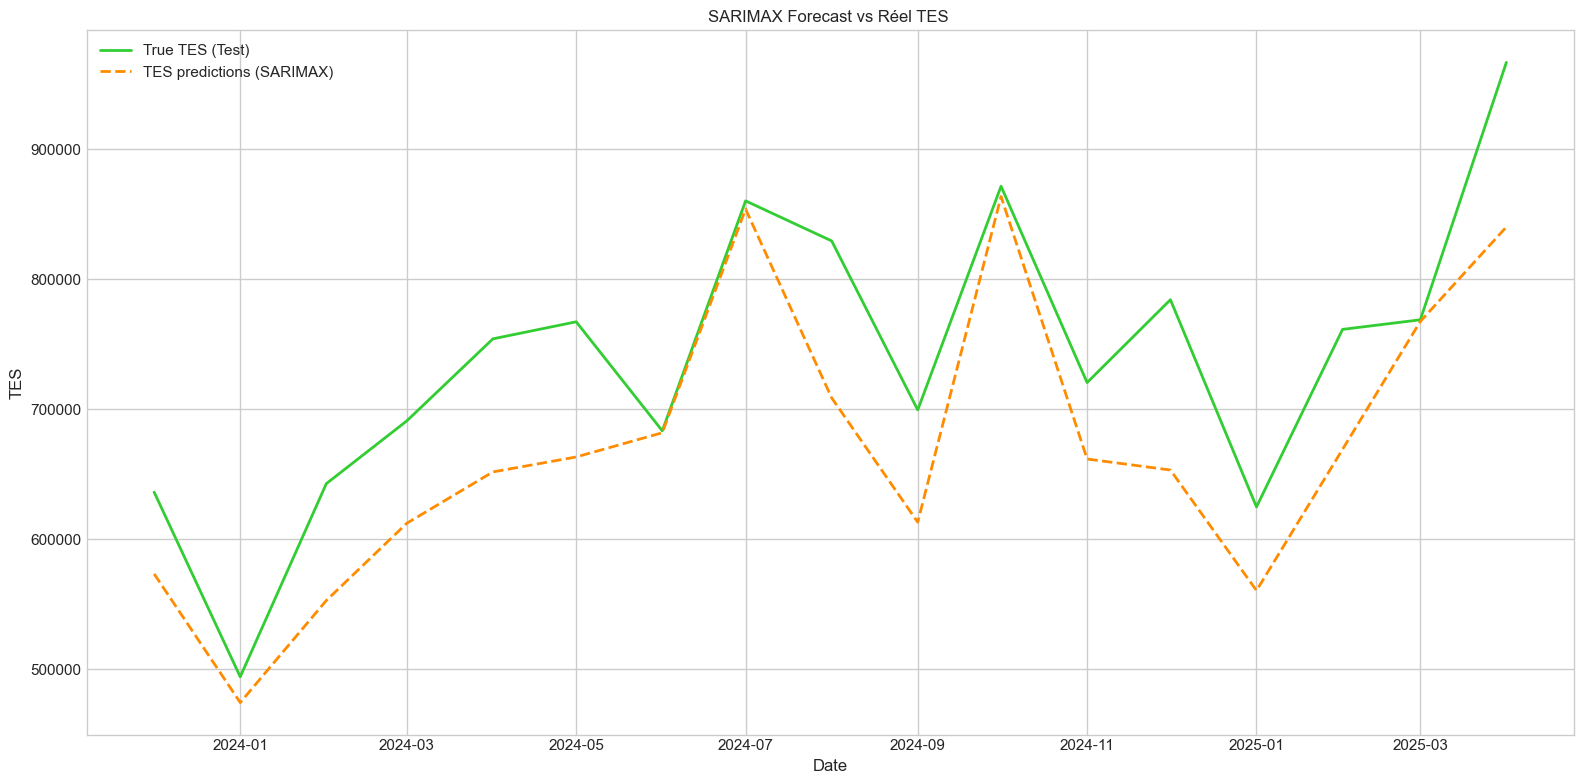

In [18]:
rmse = root_mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)
print(f"\nRMSE: {rmse:,.2f}")
print(f"MAE: {mae:,.2f}")
print(f"MAPE: {mape:,.2%}")
print(f"R²: {r2:,.2%}")
print(f"R²: {r2:.4f}")


#Visualization
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 8))
#plt.plot(train['TES'], label='Training data', color='royalblue')
plt.plot(y_test, label='True TES (Test)', color='limegreen', linewidth=2)
plt.plot(predictions, label='TES predictions (SARIMAX)', color='darkorange', linestyle='--', linewidth=2)
plt.title("SARIMAX Forecast vs Réel TES ")
plt.xlabel('Date', fontsize=12)
plt.ylabel('TES', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Expanding window

In [12]:

# Expanding window avec contraintes réelles
def forecast(df, target='TES', test=18):
    l=list(df.columns)
    l.remove('TES')
    feats = l
    train_end = len(df) - test
    preds, acts , dates = [],[], []
    
    for i in range(test):
        # Train
        print('='*40,"le test némero ",i+1,'='*40)
        train = df.iloc[:train_end + i]
        X_train, y_train = train[feats], train[target]
        model = SARIMAX(y_train,exog=X_train,order=(0,1,0),seasonal_order=(2,2,1,12))
        results = model.fit(disp=False,maxiter=200)#, cov_type='robust')
        
        # Test avec contrainte réelle
        test_row = df.iloc[[train_end + i]][feats].copy()
        start_index = test_row.index.min()
        end_index = test_row.index.max()
        pred = results.predict(start=start_index, end=end_index, exog=test_row)[0]
        preds.append(pred)
        acts.append(df.iloc[train_end + i][target])
        dates.append(df.index[train_end + i])
    
    # Métriques
    mae = mean_absolute_error(acts, preds)
    rmse = root_mean_squared_error(acts, preds)
    r2 = r2_score(acts, preds)
    mape = 100 * np.mean(np.abs((np.array(acts) - np.array(preds)) / np.array(acts)))
    
    print("="*40,"Mrtric","="*40)
    print(f"MAE: {mae:,.1f} \nRMSE: {rmse:,.1f} \nMAPE: {mape:,.1f}%")
    print(f"R²: {r2:,.2f}")
    return pd.DataFrame({'actual': acts, 'predicted': preds} , index=dates)

# UTILISATION
# df = pd.read_csv('ventes.csv')  # Vos données
# df = prep(df, date='date', target='ventes')
# results = forecast(df, test=18)

In [13]:
results1 = forecast(df, test=18)

======================================== le test némero  1 ========================================


c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\masta\AppData\Local\Temp\ipykernel_10860\1198832041.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = results.predict(start=start_index, end=end_index, exog=test_row)[0]
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
 

======================================== le test némero  2 ========================================


C:\Users\masta\AppData\Local\Temp\ipykernel_10860\1198832041.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = results.predict(start=start_index, end=end_index, exog=test_row)[0]
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


======================================== le test némero  3 ========================================


C:\Users\masta\AppData\Local\Temp\ipykernel_10860\1198832041.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = results.predict(start=start_index, end=end_index, exog=test_row)[0]
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


======================================== le test némero  4 ========================================


C:\Users\masta\AppData\Local\Temp\ipykernel_10860\1198832041.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = results.predict(start=start_index, end=end_index, exog=test_row)[0]
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


======================================== le test némero  5 ========================================


C:\Users\masta\AppData\Local\Temp\ipykernel_10860\1198832041.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = results.predict(start=start_index, end=end_index, exog=test_row)[0]
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


======================================== le test némero  6 ========================================


C:\Users\masta\AppData\Local\Temp\ipykernel_10860\1198832041.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = results.predict(start=start_index, end=end_index, exog=test_row)[0]
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


======================================== le test némero  7 ========================================


C:\Users\masta\AppData\Local\Temp\ipykernel_10860\1198832041.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = results.predict(start=start_index, end=end_index, exog=test_row)[0]
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


======================================== le test némero  8 ========================================


C:\Users\masta\AppData\Local\Temp\ipykernel_10860\1198832041.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = results.predict(start=start_index, end=end_index, exog=test_row)[0]
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


======================================== le test némero  9 ========================================


C:\Users\masta\AppData\Local\Temp\ipykernel_10860\1198832041.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = results.predict(start=start_index, end=end_index, exog=test_row)[0]
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


======================================== le test némero  10 ========================================


C:\Users\masta\AppData\Local\Temp\ipykernel_10860\1198832041.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = results.predict(start=start_index, end=end_index, exog=test_row)[0]
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


======================================== le test némero  11 ========================================


C:\Users\masta\AppData\Local\Temp\ipykernel_10860\1198832041.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = results.predict(start=start_index, end=end_index, exog=test_row)[0]
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


======================================== le test némero  12 ========================================


C:\Users\masta\AppData\Local\Temp\ipykernel_10860\1198832041.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = results.predict(start=start_index, end=end_index, exog=test_row)[0]
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


======================================== le test némero  13 ========================================


C:\Users\masta\AppData\Local\Temp\ipykernel_10860\1198832041.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = results.predict(start=start_index, end=end_index, exog=test_row)[0]
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


======================================== le test némero  14 ========================================


C:\Users\masta\AppData\Local\Temp\ipykernel_10860\1198832041.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = results.predict(start=start_index, end=end_index, exog=test_row)[0]
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


======================================== le test némero  15 ========================================


C:\Users\masta\AppData\Local\Temp\ipykernel_10860\1198832041.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = results.predict(start=start_index, end=end_index, exog=test_row)[0]
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


======================================== le test némero  16 ========================================


C:\Users\masta\AppData\Local\Temp\ipykernel_10860\1198832041.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = results.predict(start=start_index, end=end_index, exog=test_row)[0]
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


======================================== le test némero  17 ========================================


C:\Users\masta\AppData\Local\Temp\ipykernel_10860\1198832041.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = results.predict(start=start_index, end=end_index, exog=test_row)[0]
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\masta\anaconda3\envs\ML_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


======================================== le test némero  18 ========================================
======================================== Mrtric ========================================
MAE: 50,969.3 
RMSE: 61,361.5 
MAPE: 7.1%
R²: 0.72


C:\Users\masta\AppData\Local\Temp\ipykernel_10860\1198832041.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred = results.predict(start=start_index, end=end_index, exog=test_row)[0]


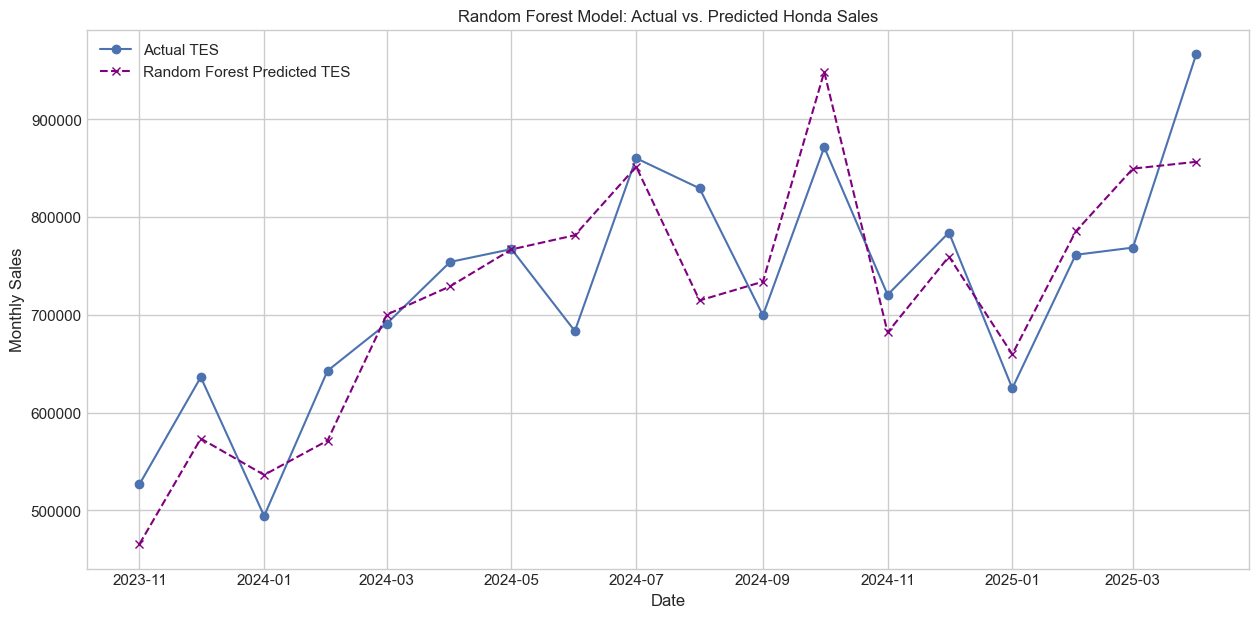

In [21]:
# Plot predictions vs. actuals
plt.figure(figsize=(15, 7))
plt.plot(results1.index, results1['actual'].values, label='Actual TES', marker='o', linestyle='-')
plt.plot(results1.index, results1['predicted'].values, label='Random Forest Predicted TES', marker='x', linestyle='--', color='purple')
plt.title('Random Forest Model: Actual vs. Predicted Honda Sales')
plt.xlabel('Date')
plt.ylabel('Monthly Sales')
plt.legend()
plt.grid(True)
plt.show()